In [1]:
import time
import numpy as np
import tensorflow as tf

In [2]:
from collections import Counter
import re

def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > 5]

    return trimmed_words

def get_batches(int_text, batch_size, seq_length):
    n_batches = int(len(int_text) / (batch_size * seq_length))
    xdata = np.array(int_text[: n_batches * batch_size * seq_length])
    ydata = np.array(int_text[1: n_batches * batch_size * seq_length + 1])
    x_batches = np.split(xdata.reshape(batch_size, -1), n_batches, 1)
    y_batches = np.split(ydata.reshape(batch_size, -1), n_batches, 1)

    return list(zip(x_batches, y_batches))

def build_dataset(words, vocabulary_size):
    count = []
    count.extend(Counter(words).most_common(vocabulary_size))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)

    data = []
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]

        data.append(index)
    
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, dictionary, reverse_dictionary

In [3]:
from urllib import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num = 1, block_size = 1, total_size = None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit = 'B', unit_scale = True, miniters = 1, desc = dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()

In [4]:
words = preprocess(text)
# i just train for 5k of words
words = words[:5000]
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [5]:
print 'total words: ' + str(len(words))
print 'total unique words: ' + str(len(set(words)))

total words: 5000
total unique words: 1411


In [6]:
_, vocab_to_int, int_to_vocab = build_dataset(words, len(words))
int_words = [vocab_to_int[word] for word in words]

In [7]:
import random

threshold = 1e-5
word_counts = Counter(int_words)
p_drop = {word: 1 - np.sqrt(threshold/word_counts[word]) for word in word_counts}
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

In [8]:
def get_target(words, idx, window_size = 8):
    R = np.random.randint(1, window_size + 1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start: idx] + words[idx + 1: stop + 1])
    
    return list(target_words)

In [9]:
class Model:
    
    def __init__(self, size_vocab, size_embedding = 200, samples = 100, learning_rate = 0.001):
        self.input = tf.placeholder(tf.int32, [None])
        self.labels = tf.placeholder(tf.int32, [None, None])
        
        self.embedding = tf.Variable(tf.random_uniform((size_vocab, size_embedding), -1, 1))
        embed = tf.nn.embedding_lookup(self.embedding, self.input)
        
        softmax_w = tf.Variable(tf.truncated_normal((size_vocab, size_embedding), stddev = 0.1))
        softmax_b = tf.Variable(tf.zeros(size_vocab))
        
        self.loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_w, softmax_b, self.labels, embed, samples, size_vocab))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.loss)

In [10]:
sess = tf.InteractiveSession()
model = Model(len(vocab_to_int))
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

In [13]:
EPOCH = 5
BATCH_SIZE = 32

for i in xrange(EPOCH):
    TOTAL_LOSS = 0
    for x in xrange(0, len(words) - BATCH_SIZE, BATCH_SIZE):
        batch_x, batch_y = [], []
        batch = train_words[x: x + BATCH_SIZE]
        for n in xrange(len(batch)):
            sample_x = batch[n]
            sample_y = get_target(batch, n)
            batch_y += sample_y
            batch_x += [sample_x] * len(sample_y)
        train_loss, _ = sess.run([model.loss, model.optimizer], 
                                 feed_dict = {model.input: batch_x, model.labels: np.array(batch_y)[:, None]})
        TOTAL_LOSS += train_loss
        
    TOTAL_LOSS /= ((len(words) - BATCH_SIZE) / BATCH_SIZE)
    print 'epoch: ' + str(i + 1) + ', average loss: ' + str(TOTAL_LOSS)

epoch: 1, average loss: nan
epoch: 2, average loss: nan
epoch: 3, average loss: nan
epoch: 4, average loss: nan
epoch: 5, average loss: nan


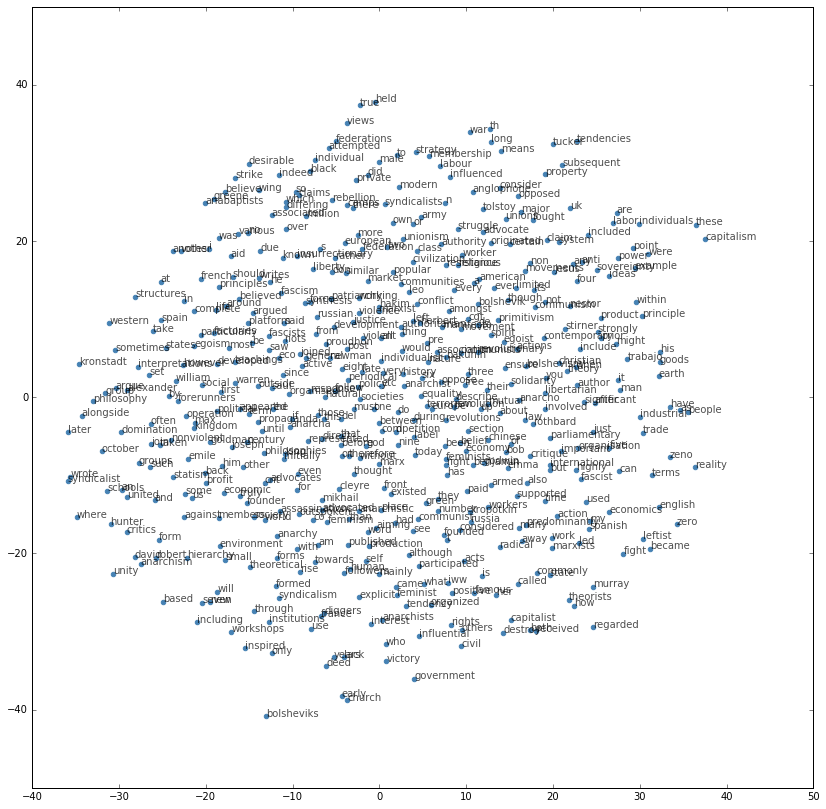

In [19]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

embed_mat = sess.run(model.embedding)
embed_tsne = TSNE().fit_transform(embed_mat[:500, :])
fig, ax = plt.subplots(figsize = (14, 14))
for idx in range(500):
    plt.scatter(embed_tsne[idx, 0], embed_tsne[idx, 1], color = 'steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha = 0.7)
    
plt.show()